In [10]:
import librosa
import numpy as np

sample_rate = 20000
def extract_features(file_path):
    audio, sample = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)

    combined_features = np.hstack([mfccs, chroma, spectral_contrast])

    return combined_features

In [11]:
import os
import pandas as pd

data = {}
paras = []
labels = []
base_path = "data/voices"

for label in os.listdir(base_path):
    folder_path = os.path.join(base_path, label)
    for f in os.listdir(folder_path):
        file_path = os.path.join(folder_path, f)
        try:
            features = extract_features(file_path)
            paras.append(features)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

data.update({'para': paras})
data.update({'label': labels})

df = pd.DataFrame(data)
print(df)
df.to_csv("emotion_dataset.csv", index=False)


                                                 para      label
0   [-600.7127685546875, 54.0293083190918, -9.0331...      happy
1   [-551.0418090820312, 46.1818733215332, -8.6652...      happy
2   [-580.90478515625, 51.67967224121094, -8.41238...      happy
3   [-601.4365844726562, 54.966163635253906, -8.88...      happy
4   [-427.555419921875, 51.5927734375, -19.2930335...      panic
5   [-407.7605895996094, 49.41276931762695, -20.93...      panic
6   [-438.4869079589844, 57.51347732543945, -16.55...      panic
7   [-622.2447509765625, 64.55450439453125, -7.008...  wondering
8   [-671.5400390625, 66.14147186279297, -2.180347...  wondering
9   [-595.01220703125, 49.81045150756836, -7.84007...  wondering
10  [-349.61590576171875, 36.182064056396484, -23....      angry
11  [-372.2358703613281, 30.115964889526367, -24.4...      angry
12  [-532.6660766601562, 48.56690216064453, -6.119...      angry
13  [-304.07275390625, 29.376861572265625, -24.706...      angry
14  [-402.7975769042969, 

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

df = pd.read_csv("emotion_dataset.csv")

df_temp = []
for i in df['para']:
    frame = [ float(num) for num in (i.strip('[]').split())]
    df_temp.append(frame)
df['para'] = df_temp

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

x = np.vstack(df['para']) #features
y = df['label'].values #labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy='auto', k_neighbors=1)
x_res, y_res = smote.fit_resample(x_train, y_train)


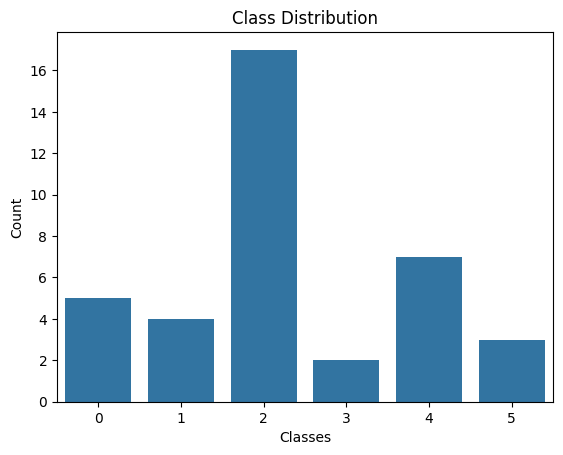

In [18]:
import seaborn as sns

sns.countplot(x=y_train)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

Model loaded from knn_emotion_recognition.pkl
Accuracy:  30.00%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00         1
           1       0.00      1.00      0.00         0
           2       1.00      0.29      0.44         7
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       0.00      1.00      0.00         0

    accuracy                           0.30        10
   macro avg       0.50      0.55      0.24        10
weighted avg       0.90      0.30      0.41        10



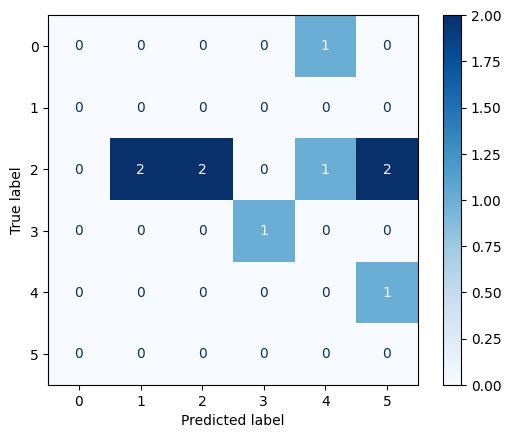

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

file_name = "knn_emotion_recognition.pkl"
if os.path.isfile(file_name):
    knn_model = joblib.load("knn_emotion_recognition.pkl")
    print(f"Model loaded from {file_name}")
else:
    knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2, weights='distance')

knn_model.fit(x_res, y_res)

y_pred = knn_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100: .2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

In [141]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7, 5],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
best_knn_model = grid_search.best_estimator_

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5}


/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [142]:
import joblib

joblib.dump(best_knn_model, "knn_emotion_recognition.pkl")

['knn_emotion_recognition.pkl']

In [ ]:
loaded_model = joblib.load("knn_emotion_recognition.pkl")

In [ ]:
file_path = ""
features = extract_features(file_path).reshape(1, -1)

predicted_label = loaded_model.predict(features)
emotion = label_encoder.inverse_transform(predicted_label)
print(f"Predicted Result: {emotion}")